<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-Importance" data-toc-modified-id="Feature-Importance-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature Importance</a></span><ul class="toc-item"><li><span><a href="#Load-Libraries" data-toc-modified-id="Load-Libraries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load Libraries</a></span></li><li><span><a href="#Load-datasets" data-toc-modified-id="Load-datasets-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load datasets</a></span></li><li><span><a href="#Perform-Preprocessing" data-toc-modified-id="Perform-Preprocessing-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Perform Preprocessing</a></span></li><li><span><a href="#Split-Data" data-toc-modified-id="Split-Data-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Split Data</a></span></li><li><span><a href="#Feature-Importance" data-toc-modified-id="Feature-Importance-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Feature Importance</a></span></li><li><span><a href="#Support-Vector-Machine" data-toc-modified-id="Support-Vector-Machine-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Support Vector Machine</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Model-improvement" data-toc-modified-id="Model-improvement-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Model improvement</a></span></li></ul></li></ul></div>

# Feature Importance
## Load Libraries

* Numpy and Pandas to handle structured data
* SkLearn train test split to comfortably split the data sets
* Sklearn Models: Support Vector Machine and Random Forest
* SkLearn Pipeline to apply same transformations to training test and prediction data sets
* SkLearn StandardScaler to normalize data
* matplotlib for plotting
* Eli5 to calculate and visualize feature importance

In [14]:
# -*- coding: utf-8 -*-
"""
@author: Simon Ruber
Sources used:
https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
https://towardsdatascience.com/extracting-feature-importances-from-scikit-learn-pipelines-18c79b4ae09a
https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn

"""
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import eli5

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from utils import accuracy, evaluation, dataFrameFromURLOrFile, plot_ROC_curve

%matplotlib inline
%reload_ext autoreload
%autoreload 2

plt.style.use("ggplot")

## Load datasets

Include the datasets wdbc and wpbc with added headers, based on the useage guidelines

In [4]:
#Feature Names Lists
feature_names_wdbc = [
    "id", "diagnosis",
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean", "compactness_mean", "concavity_mean", "concave_points_mean", "symmetry_mean", "fractal_dimension_mean",
    "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se", "compactness_se", "concavity_se", "concave_points_se", "symmetry_se", "fractal_dimension_se",
    "radius_worst", "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst", "compactness_worst", "concavity_worst", "concave_points_worst", "symmetry_worst", "fractal_dimension_worst"
]
feature_names_wpbc = [
    "id", "recurrence", "time",
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean", "compactness_mean", "concavity_mean", "concave_points_mean", "symmetry_mean", "fractal_dimension_mean",
    "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se", "compactness_se", "concavity_se", "concave_points_se", "symmetry_se", "fractal_dimension_se",
    "radius_worst", "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst", "compactness_worst", "concavity_worst", "concave_points_worst", "symmetry_worst", "fractal_dimension_worst",
    "tumor_size", "lymph_status"
]

#Load Datasets
wdbc_df = dataFrameFromURLOrFile(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data",
    "./data/wdbc.data",
    feature_names_wdbc
)

wpbc_df = dataFrameFromURLOrFile(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wpbc.data",
    "./data/wpbc.data",
    feature_names_wpbc
)
print("datasets loaded!")

datasets loaded!


## Perform Preprocessing
Encode binary target columns into integer values and remove unneeded columns like id.
To show the threshold until features may add predictive power to the model a random variable is added to the datasets

In [5]:
# Transform diagnosis column into binary int --> target
wdbc_model_data = wdbc_df.copy()
wdbc_model_data["target"] = np.where(wdbc_model_data['diagnosis'] == "M", 1, 0)
#Drop unnecessary columns
wdbc_model_data = wdbc_model_data.drop(columns=["diagnosis", "id"])

# Transform recurrence column into binary int --> target
wpbc_model_data = wpbc_df.copy()
wpbc_model_data["target"] = np.where(
    wpbc_model_data['recurrence'] == "R", 1, 0)
#Drop unnecessary columns
wpbc_model_data = wpbc_model_data.drop(
    columns=["recurrence", "id", "time", "tumor_size", "lymph_status"])

#Add a random value column
# Use seed to create repeatable "random" results
np.random.seed(42)
# Add column
wdbc_model_data["random"] = np.random.random(size=len(wdbc_model_data))
wpbc_model_data["random"] = np.random.random(size=len(wpbc_model_data))

## Split Data
Split the datasets in labels - y and features - X as preparation for model training.
Apply a train test split for wdbc data to validate the model.

In [15]:
y_wdbc = wdbc_model_data["target"]
X_wdbc = wdbc_model_data.drop("target", axis=1)

y_wpbc = wpbc_model_data["target"]
X_wpbc = wpbc_model_data.drop("target", axis=1)

# Train/test split in a .75/.25 ratio
X_train, X_test, y_train, y_test = train_test_split(
    X_wdbc, y_wdbc, test_size=.25, random_state=0)

## Feature Importance

Two feature importance functions are used:
1. The inbuilt coefficients of SVC are evaluated and visualized with a barplot
2. The Eli5 library is used to calculate the feature weights and order them by importance


In [36]:
# Generate feature importance plot based on the inbuilt SVC coefficients
def f_importancesSVC(coef, names):
    imp = coef/np.sum(coef)
    imp,names = zip(*sorted(zip(imp,names)))
    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,6))
    ax.barh(range(len(names)), imp, align='center')
    ax.set_xlabel('Weight %')
    ax.set_title('Feature Importance with SVC Coefficient')
    ax.set_yticks(range(len(names)))
    ax.set_yticklabels(names)
    plt.show()

# Generate feature importance plot based on eli5 library
def f_importances(estimator,feature_names):
    exp = eli5.explain_weights(estimator, feature_names=feature_names, top=35 )
    exp_df = eli5.format_as_dataframe(exp)
    exp_df = exp_df[exp_df["feature"] !="<BIAS>"]
    exp_df["weight"] = exp_df["weight"]/np.sum(exp_df["weight"])
    imp,names = zip(*sorted(zip(exp_df["weight"],exp_df["feature"])))
    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,6))
    ax.barh(range(len(names)), imp, align='center')
    ax.set_xlabel('Weight %')
    ax.set_title('Feature Importance')
    ax.set_yticks(range(len(names)))
    ax.set_yticklabels(names)
    plt.show()

## Support Vector Machine

A pipeline is generated and the standard scaler is added, to remove the variable mean and use unit variance. 
SVC is added to the pipeline with a linear kernel to get meaningful feature importance calculation with inbuilt SVC coefficients

The test sensitivity is 0.86
The test specificity is 0.9891304347826086
The test accuracy is 0.9436619718309859


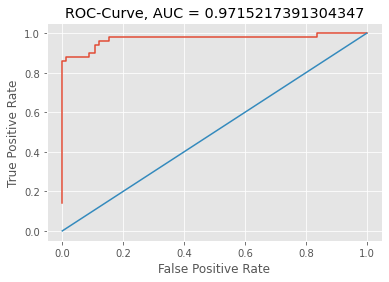

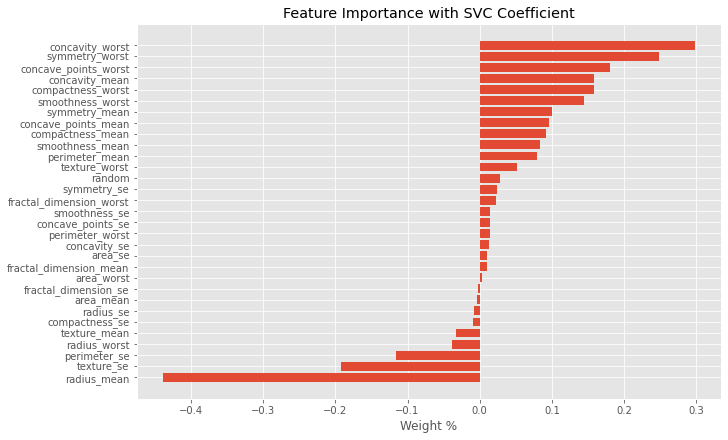

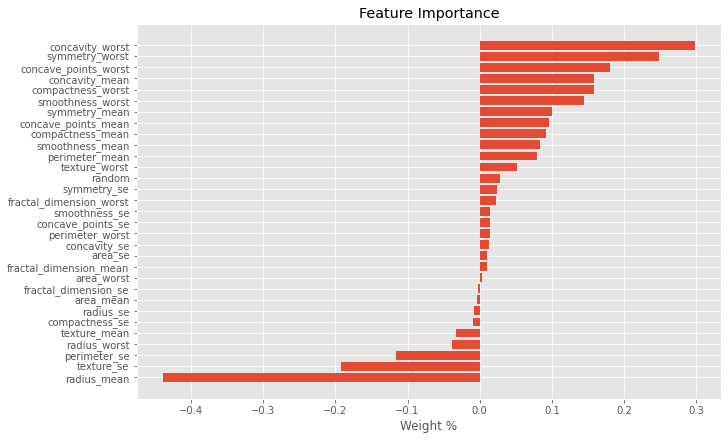

In [37]:
# Group function to train fit and evaluate the Support Vector Classifier
def trainAndFitSVC(train, test):
    sk_pipe = make_pipeline(
        SVC(kernel="linear", probability=True, random_state=0))
    sk_pipe.fit(train[0], train[1])

    # Predict labels
    y_pred_proba = sk_pipe.predict_proba(test[0])
    y_pred = sk_pipe.predict(test[0])

    test_sens, test_spec, test_acc, test_prec, test_rec = evaluation(
        test[1], y_pred)
    print("The test sensitivity is {}".format(test_sens))
    print("The test specificity is {}".format(test_spec))
    print("The test accuracy is {}".format(test_acc))

    plot_ROC_curve(test[1], y_pred_proba[:, 1])
    f_importancesSVC(sk_pipe.named_steps['svc'].coef_[0], list(train[0].columns))
    f_importances(sk_pipe.named_steps['svc'], list(train[0].columns))

trainAndFitSVC((X_train, y_train), (X_test, y_test))

## Random Forest

A pipeline is generated and the standard scaler is added, to remove the variable mean and use unit variance. 
SVC is added to the pipeline with a linear kernel to get meaningful feature importance calculation with inbuilt SVC coefficients

The test sensitivity is 0.88
The test specificity is 0.9891304347826086
The test accuracy is 0.9507042253521126


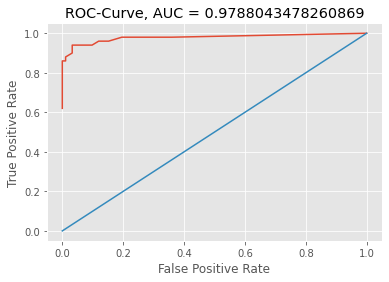

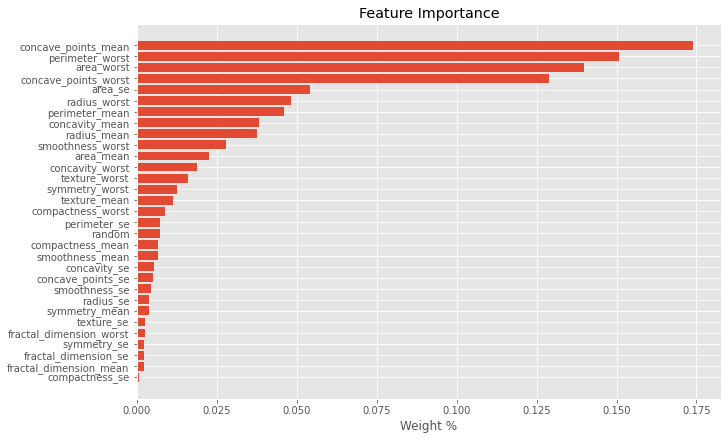

In [38]:
# Group function to train fit and evaluate the Random Forest Classifier
def trainAndFitRFC(train, test):
    sk_pipe = make_pipeline(StandardScaler(),RFC(n_estimators=20,random_state=0))
    sk_pipe.fit(train[0], train[1])

    # Predict labels
    y_pred_proba = sk_pipe.predict_proba(test[0])
    y_pred = sk_pipe.predict(test[0])

    test_sens, test_spec, test_acc, test_prec, test_rec = evaluation(test[1], y_pred)
    print("The test sensitivity is {}".format(test_sens))
    print("The test specificity is {}".format(test_spec))
    print("The test accuracy is {}".format(test_acc))

    plot_ROC_curve(test[1], y_pred_proba[:, 1])
    f_importances(sk_pipe.named_steps['randomforestclassifier'], list(train[0].columns))
    
trainAndFitRFC((X_train,y_train),(X_test,y_test))

## Model improvement

The most important features in the SVC model are: 
1. concavity_worst
2. symmetry_worst
3. concave_points_worst
4. concavity_mean

The most important features in the Random Forest model are: 
1. concave_points_mean, 
2. perimeter_worst,
3. area_worst and 
4. concave_points_worst

Those features are now used within new models

In [45]:
#X_wdbc_reduced_rf = wdbc_df[["concave_points_mean","perimeter_worst", "area_worst", "concave_points_worst"]]
#X_wdbc_reduced_svc = wdbc_df[["concavity_worst","symmetry_worst", "concave_points_worst", "concavity_mean"]]

X_wdbc_reduced_rf = wdbc_df[["area_worst","smoothness_worst", "texture_mean"]]
X_wdbc_reduced_svc = wdbc_df[["area_worst","smoothness_worst", "texture_mean"]]

X_train2_rf, X_test2_rf, y_train2_rf, y_test2_rf = train_test_split(
    X_wdbc_reduced_rf, y_wdbc, test_size=.25, random_state=0)
X_train2_svc, X_test2_svc, y_train2_svc, y_test2_svc = train_test_split(
    X_wdbc_reduced_svc, y_wdbc, test_size=.25, random_state=0)

The test sensitivity is 0.9
The test specificity is 0.967391304347826
The test accuracy is 0.9436619718309859


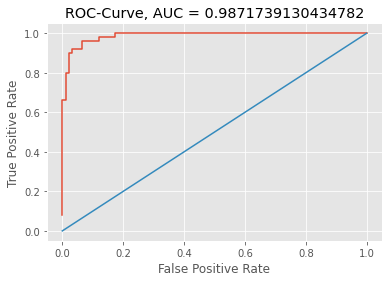

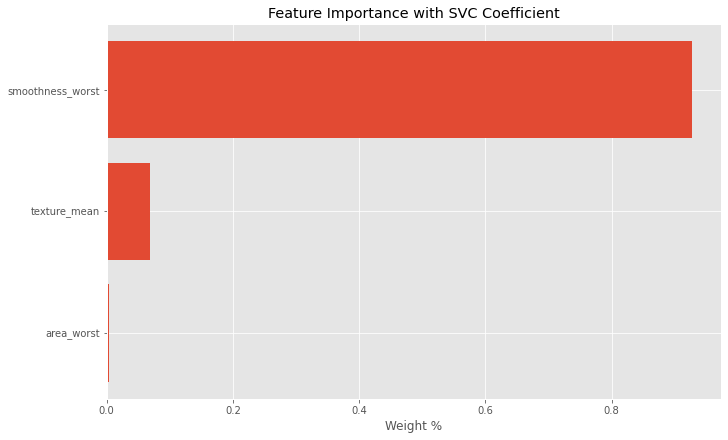

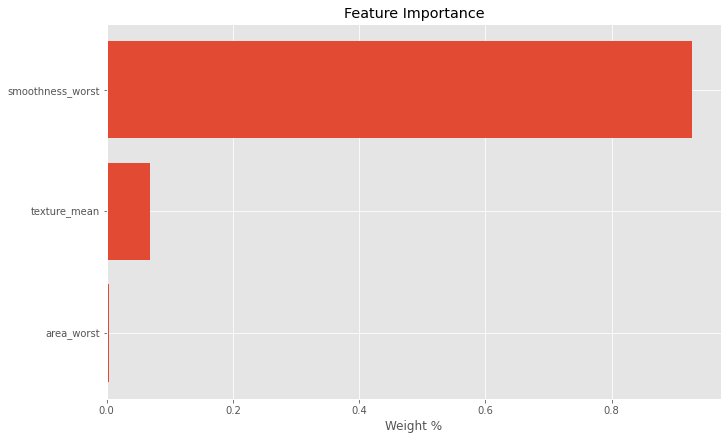

In [46]:
trainAndFitSVC((X_train2_svc,y_train2_svc),(X_test2_svc,y_test2_svc))

The test sensitivity is 0.9
The test specificity is 0.9782608695652174
The test accuracy is 0.9507042253521126


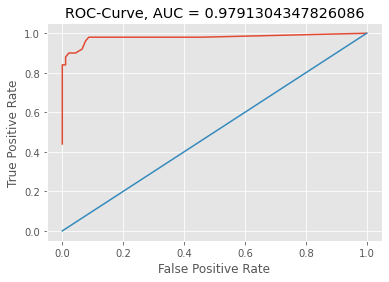

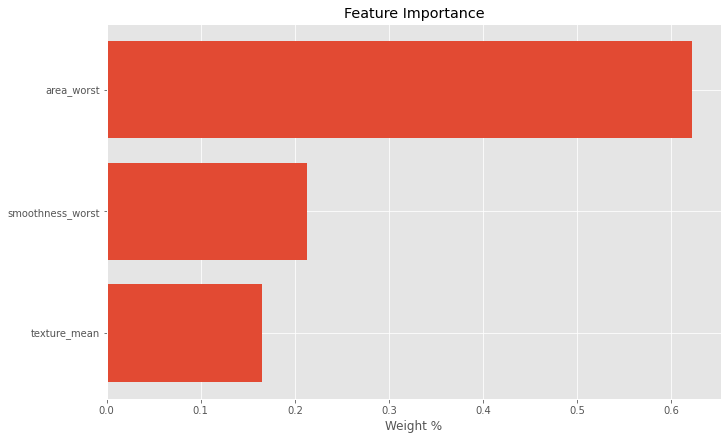

In [47]:
trainAndFitRFC((X_train2_rf,y_train2_rf),(X_test2_rf,y_test2_rf))